In [134]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
sns.set_theme(style="ticks", palette="deep")

from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import ruamel.yaml as yaml
import torch
import scipy.stats as stats

from soul_gan.datasets.utils import get_dataset, prepare_2d_gaussian_grid_data, prepare_2d_ring_data

from soul_gan.utils.general_utils import DotConfig, CONFIGS_DIR, DATA_DIR
from soul_gan.models.utils import GANWrapper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
config = DotConfig(yaml.round_trip_load(Path(CONFIGS_DIR, 'gan_configs/ring-mlp.yml').open('r'))).gan_config

mean = np.array(config.train_transform.Normalize.mean)
std = np.array(config.train_transform.Normalize.std)

In [137]:
sample, modes = prepare_2d_ring_data(int(5e3))
#modes = modes[:1]
np.savez(
    Path(DATA_DIR, '8_gaussians_modes.npz').open('wb'), 
    centroids=(modes - mean[None, :]) / std[None, :], 
    closest_pts=(modes - mean[None, :]) / std[None, :], 
    sigmas=np.ones(len(modes))*0.02 / std[0],
    priors=np.ones(len(modes)) / len(modes))

In [138]:
kind = 'ring'

dataset = get_dataset(f"gaussians_{kind}", int(5e3))
dataset[0]

tensor([1.9928, 0.0269])

In [161]:
def plot(target, feature, step_size, suffix='', step=1000):
    path = Path(f'../log/{feature}_{target}Target/mlp_{kind}{suffix}_{step_size}')
    xs = np.load(Path(path, f'images/{step}.npy'))

    plt.figure(figsize=(5, 5))
    plt.scatter(xs[:, 0], xs[:, 1], alpha=0.1, s=10)
    plt.axis('equal')
    plt.grid()

    Path(path, 'figs').mkdir(exist_ok=True)
    plt.savefig(Path(path, f'figs/{kind}{suffix}_{step_size}_2d_{step}.png'))

In [162]:
step_size = 0.001

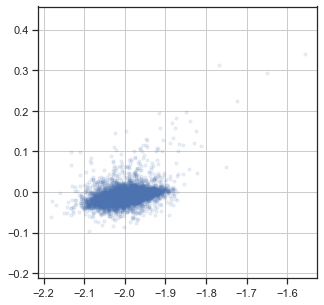

In [163]:
target = 'Discriminator'
feature = 'dumb_feature'

plot(target, feature, step_size, step=0)

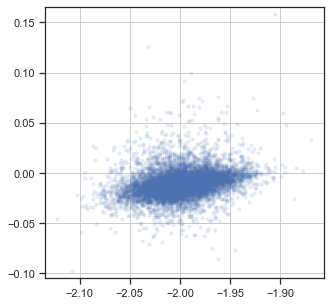

In [164]:
target = 'Discriminator'
feature = 'dumb_feature'

plot(target, feature, step_size)

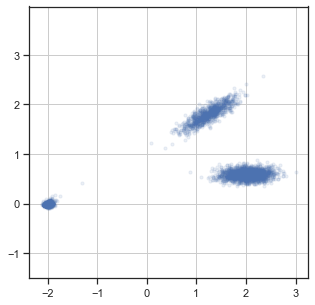

In [165]:
step_size = 0.1
target = 'Discriminator'
feature = 'cluster_feature'

plot(target, feature, step_size, suffix='_v1')


In [166]:
device = torch.device(0)

config = DotConfig(yaml.round_trip_load(Path(CONFIGS_DIR, 'gan_configs/ring-mlp.yml').open('r'))).gan_config
gan = GANWrapper(config, device)
gen = gan.gen
dis = gan.dis

In [167]:
n_pts_ax = 100
n_kde_pts = 50000
latent_grid = np.meshgrid(np.linspace(-3, 3, n_pts_ax), np.linspace(-3, 3, n_pts_ax))
real_grid = np.meshgrid(np.linspace(-2.5, 2.5, n_pts_ax), np.linspace(-2.5, 2.5, n_pts_ax))

zs = gen.prior.sample((n_kde_pts,))
xs_normalized = gen(zs)
xs = gen.inverse_transform(xs_normalized).detach().cpu().numpy()
dgz = dis(xs_normalized).squeeze().detach().cpu().numpy()

reals = torch.from_numpy(np.stack(real_grid, -1).reshape(-1, 2)).to(device).float()
dgz_ = dis(dis.transform(reals)).squeeze()

reals_np = reals.detach().cpu().numpy()

In [168]:
dgz_.mean(), dgz.mean()

(tensor(-2.3994, device='cuda:0', grad_fn=<MeanBackward0>), -1.7653658)

In [169]:
kde = stats.kde.gaussian_kde(xs.transpose(1, 0))
log_probs = kde.logpdf(reals_np.transpose(1, 0))

Text(0.5, 1.0, '$-\\hat{E}(x) = \\log p_G(x) + d(x)$')

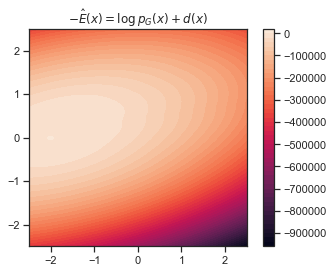

In [170]:
energy = (log_probs + dgz_.detach().cpu().numpy())
energy_grid = energy.reshape(n_pts_ax, n_pts_ax)
#Path('../figs/100gaussians').mkdir(exist_ok=True)

xs_grid = reals_np.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], energy_grid, levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$-\hat{E}(x) = \log p_G(x) + d(x)$')
#plt.savefig(Path('../figs/100gaussians', 'minus_energy_sigma_0.025.png'))

Text(0.5, 1.0, '$\\log p_G(x)$')

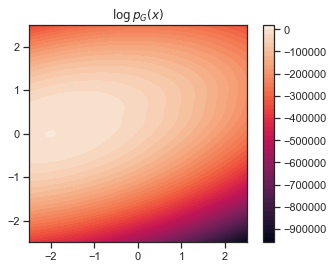

In [171]:
xs_grid = reals_np.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], log_probs.reshape(n_pts_ax, n_pts_ax), levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$\log p_G(x)$')
# plt.savefig(Path('../figs/100gaussians', 'log_prob_0.025.png'))

Text(0.5, 1.0, '$d(x)$')

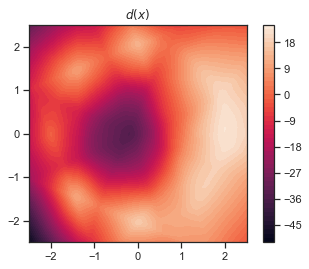

In [172]:
xs_grid = reals_np.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], dgz_.detach().cpu().numpy().reshape(n_pts_ax, n_pts_ax), levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$d(x)$')
# plt.savefig(Path('../figs/100gaussians', 'dgz_0.025.png'))

In [173]:
modes

array([[ 2.00000000e+00,  0.00000000e+00],
       [ 1.41421356e+00,  1.41421356e+00],
       [ 1.22464680e-16,  2.00000000e+00],
       [-1.41421356e+00,  1.41421356e+00],
       [-2.00000000e+00,  2.44929360e-16],
       [-1.41421356e+00, -1.41421356e+00],
       [-3.67394040e-16, -2.00000000e+00],
       [ 1.41421356e+00, -1.41421356e+00]])

In [174]:
mode = torch.as_tensor(modes[-1]).to(device)

loss_f = lambda z: torch.norm(mode[None, :] - gen(z), dim=-1)

xs = []
z = gan.prior.sample((1,)).to(device).requires_grad_(True)
for it in range(1000):
    xs.append(z.detach())
    loss = loss_f(z)
    grad = torch.autograd.grad(loss.sum(0), z)[0]
    z = z - 1 * grad

    if it % 10 == 0:
        print(loss.mean().item()) 


3.700699515546076
3.6709472162725842
3.6463756887953265
3.623015845780651
3.601187754186761
3.580479523335019
3.561360739805
3.543570746499113
3.5270759575824586
3.5108152193420845
3.493326829926756
3.477166651492788
3.463640466497801
3.451549860356401
3.440402715999605
3.429162238766728
3.4193305998053085
3.404505703812292
3.38718140284844
3.3740146239284345
3.361252326813493
3.349932094125758
3.339233630426521
3.3295946778617362
3.3217303423895297
3.3127184731311745
3.305087763854793
3.2939706255222205
3.252507844911353
3.033471419091895
2.8013018993438776
2.720051448481376
2.6735063352056803
2.639947420224688
2.611824533137397
2.5831767285355967
2.560450864389428
2.542680827976479
2.5273959172766767
2.5125444870368443
2.4969622922066215
2.4811943521960966
2.4654726527241317
2.451087473627507
2.4379027549080967
2.4113506158030082
2.3841852317915877
2.358744903565139
2.3345276689230756
2.3109535351316484
2.2877669643687
2.265250176126592
2.2419129756326956
2.2186408723474047
2.1958402

In [175]:
xs = gen(torch.cat(xs, 0)).detach().cpu().numpy()

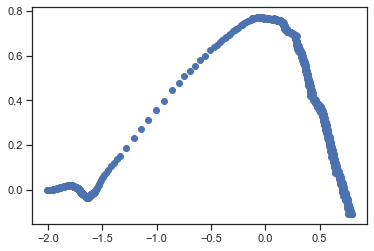

In [176]:
plt.scatter(xs[:, 0], xs[:, 1])